In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import FeatEngFun
importlib.reload(FeatEngFun)
from FeatEngFun import titanic_feature_eng
from FeatEngFun import cabin_imputing_fun
import numpy as np
import pickle
import os

DATASET = 'train.csv'

data = pd.read_csv(DATASET, index_col = 0)

data.head()

if DATASET == 'test.csv':
    if not os.path.exists('scaler.pkl') and not os.path.exists('updated_models.pkl') and not os.path.exists('enable_grid_search.pkl'):
        user_input = input("One of the files required to perform the operations on the test set could not be found. Would you like to run the program using the training set to solve the errors? (Y/N): ").strip().lower()
        if user_input == 'y':
            DATASET = 'train.csv'
            data = pd.read_csv(DATASET, index_col=0)
            [dataframe, cabins] = titanic_feature_eng(data, DATASET, drop_all=True, cabin_pca=True, cabin_group_encoding=True)
            print(dataframe)
        else:
            raise FileNotFoundError("The file 'FEng_stats_imputing' could not be found. Please run the program with the training set first.")

[dataframe, cabins] = titanic_feature_eng(data, DATASET, drop_all=True, cabin_pca=False, cabin_group_encoding=True)
print(dataframe)


The dataset given is the training set.
             Survived  Pclass  Sex        Age     Fare  Cabin CabinLetter
PassengerId                                                              
1                   0       3    0  22.000000   7.2500    NaN         NaN
2                   1       1    1  38.000000  71.2833    0.0           C
3                   1       3    1  26.000000   7.9250    NaN         NaN
4                   1       1    1  35.000000  53.1000    0.0           C
5                   0       3    0  35.000000   8.0500    NaN         NaN
...               ...     ...  ...        ...      ...    ...         ...
887                 0       2    0  27.000000  13.0000    NaN         NaN
888                 1       1    1  19.000000  30.0000    0.0           B
889                 0       3    1  29.699118  23.4500    NaN         NaN
890                 1       1    0  26.000000  30.0000    0.0           C
891                 0       3    0  32.000000   7.7500    NaN         NaN

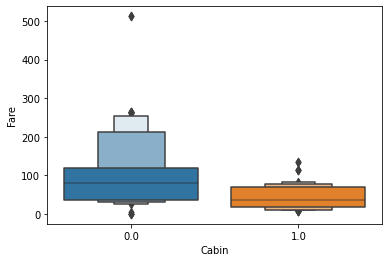

The average fare price per cluster is:
            mean  median
Cabin                   
0.0    97.835193    79.2
1.0    44.515765    35.5
0.0    0.593137
1.0    0.406863
Name: Cabin, dtype: float64
Cabin                   0.0      1.0
Fare_Interval                       
(-0.001, 170.776]   0.55615  0.44385
(170.776, 341.553]  1.00000  0.00000
(341.553, 512.329]  1.00000  0.00000


In [14]:
plt.figure()
sns.boxenplot(x = 'Cabin', y = 'Fare', data = dataframe)
plt.show()

print('The average fare price per cluster is:')
print(dataframe.groupby('Cabin')['Fare'].agg(['mean', 'median']))
print(dataframe['Cabin'].value_counts(normalize=True))


# Assuming your data has 'Fare' and 'cluster' columns

# Step 1: Define the number of intervals and calculate fare ranges
num_intervals = 3
fare_min, fare_max = dataframe['Fare'].min(), dataframe['Fare'].max()
fare_bins = np.linspace(fare_min, fare_max, num_intervals + 1)  # Create interval edges

# Step 2: Create a new column 'Fare_Interval' to classify fares into intervals
dataframe['Fare_Interval'] = pd.cut(dataframe['Fare'], bins=fare_bins, include_lowest=True)

# Step 3: Calculate proportions of passengers in clusters 0 and 1 by fare interval
""" fare_cluster_proportions = pd.crosstab(
    index=dataframe['Fare_Interval'],      # Fare intervals
    columns=dataframe['Cabin'],          # Clusters 0 and 1
    normalize='index'                 # Proportion by each interval
)[[0, 1]]  # Only select clusters 0 and 1 """

fare_cluster_proportions = pd.crosstab(
    index=dataframe['Fare_Interval'],      # Fare intervals
    columns=dataframe['Cabin'],          # Clusters 0 and 1
    normalize='index'                 # Proportion by each interval
) # Only select clusters 0 and 1


# Step 4: Display the result
print(fare_cluster_proportions)

In [15]:
 # Imputing the Cabins based on the cluster/cabin average fare price.

dataframe = cabin_imputing_fun(dataframe)

print(dataframe.isna().sum())# Splitting the datasets

dataframe.head()

Average prices for cabins depending on the cabin floor are the following: 
 Cabin
0.0    97.835193
1.0    44.515765
Name: Fare, dtype: float64
Survived           0
Pclass             0
Sex                0
Age                0
Fare               0
Cabin              0
CabinLetter      687
Fare_Interval      0
dtype: int64


,Survived,Pclass,Sex,Age,Fare,Cabin,CabinLetter,Fare_Interval
PassengerId,,,,,,,,
1,0,3,0,22.0,7.2500,1.0,NaN,"(-0.001, 170.776]"
2,1,1,1,38.0,71.2833,0.0,C,"(-0.001, 170.776]"
3,1,3,1,26.0,7.9250,1.0,NaN,"(-0.001, 170.776]"
4,1,1,1,35.0,53.1000,0.0,C,"(-0.001, 170.776]"
5,0,3,0,35.0,8.0500,1.0,NaN,"(-0.001, 170.776]"


In [16]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import GridSearch
importlib.reload(GridSearch)
from GridSearch import gridsearch_fun

standardized_columns = ['Age', 'Fare']

if DATASET == 'train.csv':
    X = dataframe.drop(['Survived', 'CabinLetter', 'Fare_Interval'], axis = 1)
    y = dataframe['Survived']

    # Dropping the columns uncessary to the models

    #dataframe.drop(['CabinLetter', 'Fare_Interval'], axis = 1)

    # The dataframe is now clean, ready to be split and used to

    # Segmentation of the sets "X" et "y" into test (20%) and training sets (80%). 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)


    scaler = StandardScaler()
    
    scaler.fit(X_train[standardized_columns])
    # Saving the standard scaler to a file to be reused on the test set
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    X_train[standardized_columns] = scaler.transform(X_train[standardized_columns])
    X_test[standardized_columns] = scaler.transform(X_test[standardized_columns])


    ### Performing a gridsearch ###

    enable_grid_search = gridsearch_fun(X_train, X_test, y_train, y_test)
    

elif DATASET == 'test.csv':

    # In case the test set is selected: 

    # 1. The potential models to use on the test set have to be saved
    # in the updated_models file, that is after running the model grid-
    # search.

    # Check if the file exists in the current directory
    file_path = 'updated_models.pkl'

    if os.path.exists(file_path):
        print(f"The file '{file_path}' exists.")
    else:
        print(f"The file '{file_path}' does not exist.")
        raise FileNotFoundError("The file 'updated_models' could not be found.")
    
    # 2. Dropping the Fare Cluster and the Cabin Letter columns.

    X = dataframe.drop(['CabinLetter', 'Fare_Interval'], axis = 1)

    # 3. Verifying that no missing values are present in the test set. 
    # If there are any either choose to impute them or drop the corres-
    # ponding rows.

    nan_values = X.isna().sum()
    print(nan_values)
    nan_columns = nan_values[nan_values > 0].index.tolist()
    if len(nan_columns) != 0:
        print(f"Columns with NaN values: {nan_columns}")
        user_input = input("Would you like to impute the missing values? (Y/N): ").strip().lower()
        if user_input == 'n':
            X = X.dropna(axis=0)
            print("The rows with missing values have been dropped.")
        else:
            impute_input = input("What imputing technique would you like to apply (1: mean, 2: median, 3: mode)? (Y/N): ").strip().lower()
            impute_techniques = {1: 'mean', 2: 'median', 3: 'mode'}

            if int(impute_input) in impute_techniques.keys():
                technique = impute_techniques[int(impute_input)]

                if technique == 'mean':
                    X[nan_columns] = X[nan_columns].fillna(X[nan_columns].mean())

                elif technique == 'median':
                    X[nan_columns] = X[nan_columns].fillna(X[nan_columns].median())

                elif technique == 'mode':
                    X[nan_columns] = X[nan_columns].fillna(X[nan_columns].mode().iloc[0])
                print(f"The missing values have been imputed using {technique}.")

            else:
                raise ValueError("Invalid imputing technique selected.")

    # 4. Opening the save models and scaler from the training set and
    # scaling the columns the columns that require it. 

    with open('updated_models', 'rb') as f:
        updated_models = pickle.load(f)

    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    with open('enable_grid_search', 'rb') as f:
        enable_grid_search = pickle.load(f)

  
    X[standardized_columns]  = scaler.transform(X[standardized_columns])


    # 5. The models have to be used to perform predictions on the test 
    # set.

    # Setting up the directory in which to save the prediction files if
    # it does not yet exist.

    if not os.path.exists('Predictions'):
        os.mkdir('Predictions')

    predictions_directory = 'Predictions'
    print(X.head())

    for model_name in enable_grid_search:
        opti_predictions = updated_models[model_name].predict(X)
        print(len(opti_predictions))

        prediction_filename = f'submission_{model_name}_predictions.csv'

        prediction_dataframe = pd.DataFrame({'PassengerId': X.index, 'Survived': opti_predictions})
        prediction_dataframe.to_csv(os.path.join(predictions_directory,prediction_filename), index = False, header = True)
    
    print(f"The predictions have been saved to the {predictions_directory} directory.")



Fitting 2 folds for each of 20 candidates, totalling 40 fits


The best version of the Logistic Regression model is :

 LogisticRegression(C=2.3000000000000003, class_weight='balanced',
                   max_iter=10000, random_state=42, solver='liblinear') 


Fitting 2 folds for each of 31 candidates, totalling 62 fits


The best version of the Random Forest model is :

 RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, n_estimators=117, random_state=42) 


Fitting 2 folds for each of 40 candidates, totalling 80 fits


The best version of the Support Vector Machine model is :

 SVC(class_weight='balanced', probability=True, random_state=42) 


Fitting 2 folds for each of 30 candidates, totalling 60 fits


The best version of the Support Vector Machine 2 model is :

 SVC(C=0.5, class_weight='balanced', degree=1, kernel='poly', probability=True,
    random_state=42) 


Fitting 2 folds for each of 420 candidates, totalling 840 fits

